In [35]:
import re
import random
import pandas as pd
import hashlib

In [36]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.75) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [37]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Azure Functions + PP365,351.176793,7.471847,47
SharePoint,351.315032,20.665590,17
Azure AI Search,474.600020,33.900001,14
Python,727.033006,121.172168,6
Lost in a Good Book,748.859768,37.442988,20
Network Mapping,806.096075,38.385527,21
Taxes,989.086447,98.908645,10
Finance Junk,1113.324179,139.165522,8
Search Engine Optimization,1341.416257,78.906839,17
PP365,1438.310296,143.831030,10


# Histogram

41541.37


<Axes: >

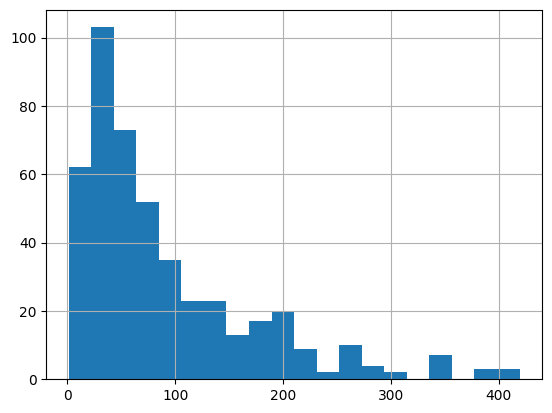

In [38]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [39]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [40]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 461


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
0,Azure Kubernetes Learning Path,"To place a container in the run state, use the...",1abb94191f23a7cb994a42c5312777b1,419.480192,143.889392,419.480192,2590.009062,0.238697
1,Home Network Project,Front: What command is used to generate a new ...,532c6a2bdc56e7a3865bb120c37f8869,411.775759,167.168398,411.775759,3510.536359,0.007519
2,Azure Kubernetes Learning Path,You can remove an image from the local compute...,987bf4aa9d988a8eda49607e62aa29f3,410.299978,143.889392,419.480192,2590.009062,0.238697
3,Azure Functions,Human interaction: This pattern combines autom...,7134e10a9d196c60ca31174c4565c8f9,388.310525,101.397239,388.310525,1723.753069,0.995221
4,DNS,TSIG (Transaction SIGnature)\nA security proto...,b9f94c468889ea3986e6f4b5309ccc9e,380.668105,150.756089,380.668105,3015.121787,0.010589
5,Home Network Project,Front: What is Snort and how is it used in net...,683e252e6cd1d5d4c6a922595ea870c2,379.962409,167.168398,411.775759,3510.536359,0.007519
6,IW Migration,VBA Modules (Access)\nVisual Basic for Applica...,ee6efc2896d6f87df85bd5db7971745b,354.216441,145.209712,354.216441,3194.613669,0.963577
7,PP365,System-Assigned Managed Identity\nA type of ma...,66ea1257c8446ccb130d030d7803c521,351.492859,143.831030,351.492859,1438.310296,0.476285
8,IW Migration,Linked Server (SQL Server)\nA configuration th...,fa3ffa381d1fcef8e1ca182752dc366d,349.957467,145.209712,354.216441,3194.613669,0.963577
9,Powershell,Start-Service\nStarts a Windows service by nam...,678b4e19869c1a72f5aa179b6733ec92,347.146557,139.060566,347.146557,2920.271879,0.365733


# Headers with fewest notes first

In [41]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [42]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [43]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [44]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [45]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [46]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [47]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [48]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [49]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)


In [50]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
0,Azure Kubernetes Learning Path,"To place a container in the run state, use the...",1abb94191f23a7cb994a42c5312777b1,419.480192,143.889392,419.480192,2590.009062,0.238697
1,Home Network Project,Front: What command is used to generate a new ...,532c6a2bdc56e7a3865bb120c37f8869,411.775759,167.168398,411.775759,3510.536359,0.007519
2,Azure Kubernetes Learning Path,You can remove an image from the local compute...,987bf4aa9d988a8eda49607e62aa29f3,410.299978,143.889392,419.480192,2590.009062,0.238697
3,Azure Functions,Human interaction: This pattern combines autom...,7134e10a9d196c60ca31174c4565c8f9,388.310525,101.397239,388.310525,1723.753069,0.995221
4,DNS,TSIG (Transaction SIGnature)\nA security proto...,b9f94c468889ea3986e6f4b5309ccc9e,380.668105,150.756089,380.668105,3015.121787,0.010589
5,Home Network Project,Front: What is Snort and how is it used in net...,683e252e6cd1d5d4c6a922595ea870c2,379.962409,167.168398,411.775759,3510.536359,0.007519
6,IW Migration,VBA Modules (Access)\nVisual Basic for Applica...,ee6efc2896d6f87df85bd5db7971745b,354.216441,145.209712,354.216441,3194.613669,0.963577
7,PP365,System-Assigned Managed Identity\nA type of ma...,66ea1257c8446ccb130d030d7803c521,351.492859,143.831030,351.492859,1438.310296,0.476285
8,IW Migration,Linked Server (SQL Server)\nA configuration th...,fa3ffa381d1fcef8e1ca182752dc366d,349.957467,145.209712,354.216441,3194.613669,0.963577
9,Powershell,Start-Service\nStarts a Windows service by nam...,678b4e19869c1a72f5aa179b6733ec92,347.146557,139.060566,347.146557,2920.271879,0.365733


In [51]:
existing_cards.head(10)['age'].sum()

3793.310290755421